In [1]:
import math
import warnings
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set_style("darkgrid")
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/online_retail_II.csv")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [5]:
invoice_customer_map = df.dropna().groupby('Invoice')['Customer ID'].agg('first')
df['Customer ID'] = np.where(df['Customer ID'].isnull(), invoice_customer_map.get(df['Invoice'], np.nan), df['Customer ID'])
df.dropna(inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Invoice'].str.startswith('C') == False]  # Startswith 'C' -> canceled order

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805620 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805620 non-null  object        
 1   StockCode    805620 non-null  object        
 2   Description  805620 non-null  object        
 3   Quantity     805620 non-null  int64         
 4   InvoiceDate  805620 non-null  datetime64[ns]
 5   Price        805620 non-null  float64       
 6   Customer ID  805620 non-null  float64       
 7   Country      805620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.3+ MB


# Cohort Analysis: Customer Behaviours

### Cohort Retention

In [7]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('Customer ID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01,2009-12-01


In [8]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
df['CohortIndex'] = years_diff * 12 + months_diff + 1
df['MoneySpent'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth,CohortIndex,MoneySpent
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01,2009-12-01,1,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12-01,1,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12-01,1,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01,2009-12-01,1,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01,2009-12-01,1,30.0


In [9]:
df_invoice_lvl = df.groupby('Invoice', as_index=False)[['Quantity','Customer ID','Country','InvoiceMonth','CohortMonth','CohortIndex','MoneySpent']]
df_invoice_lvl = df_invoice_lvl.agg({'Quantity':'sum','Customer ID':'first','Country':'first','InvoiceMonth':'first','CohortMonth':'first','CohortIndex':'first','MoneySpent':'sum'})
df_invoice_lvl.head()

,Invoice,Quantity,Customer ID,Country,InvoiceMonth,CohortMonth,CohortIndex,MoneySpent
0,489434,166,13085.0,United Kingdom,2009-12-01,2009-12-01,1,505.30
1,489435,60,13085.0,United Kingdom,2009-12-01,2009-12-01,1,145.80
2,489436,193,13078.0,United Kingdom,2009-12-01,2009-12-01,1,630.33
3,489437,145,15362.0,United Kingdom,2009-12-01,2009-12-01,1,310.75
4,489438,826,18102.0,United Kingdom,2009-12-01,2009-12-01,1,2286.24


In [10]:
grouping = df_invoice_lvl.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Customer ID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='Customer ID'
)

In [11]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index = retention.index.astype(str)

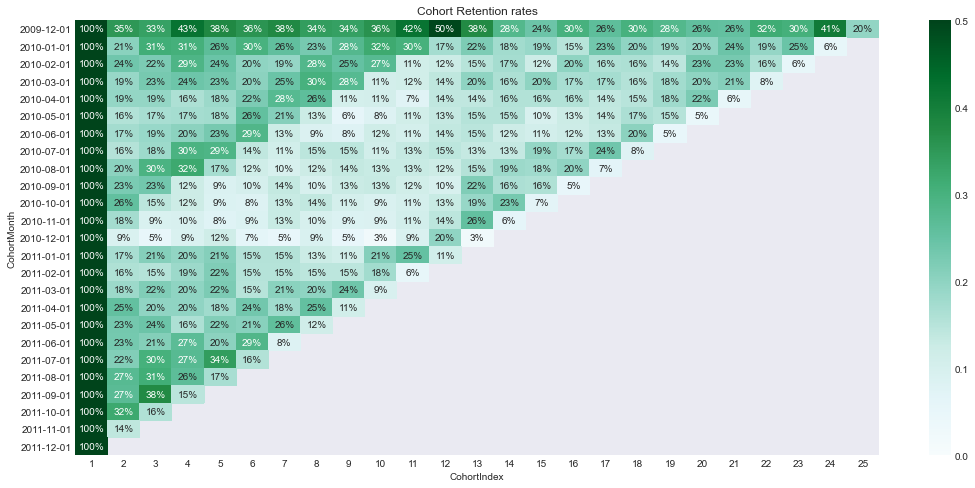

In [12]:
def cohort_heatmap(table, title, size, vmin, vmax, fmt, cmap):
    plt.figure(figsize=size)
    plt.title(title)
    sns.heatmap(
        data=table,
        annot=True,
        fmt=fmt,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap
    )
    plt.show()

cohort_heatmap(retention, 'Cohort Retention rates', (18,8), 0.0, 0.5,'.0%','BuGn')

### Cohort Avg Quantity Bought per Invoice

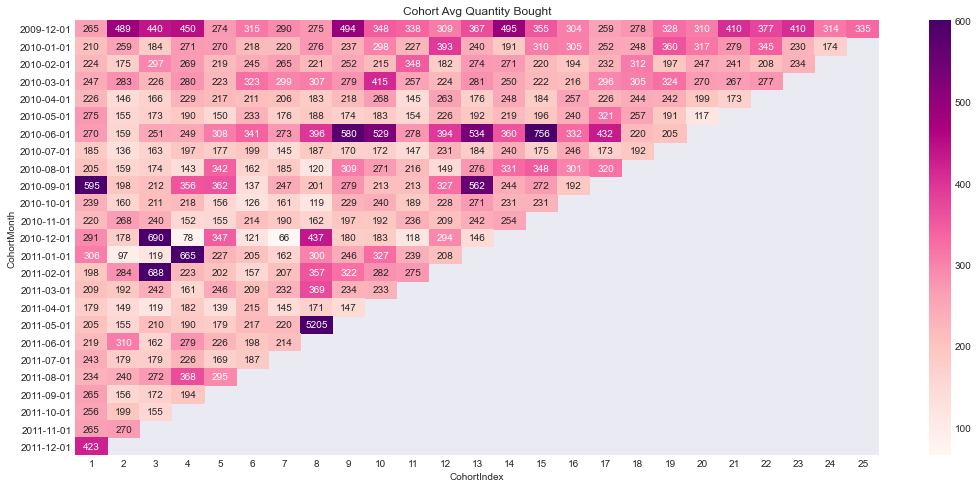

In [13]:
grouping = df_invoice_lvl.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean().round(0)
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='Quantity')
average_quantity.index = average_quantity.index.astype(str)
cohort_heatmap(average_quantity, 'Cohort Avg Quantity Bought', (18,8), None, 600,'.0f','RdPu')

### Cohort Avg Money Spent per Invoice

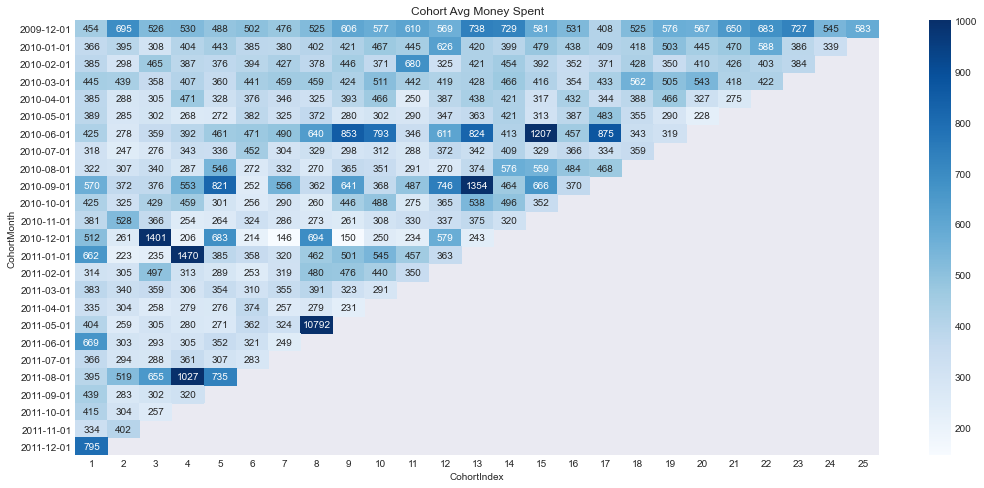

In [14]:
grouping = df_invoice_lvl.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['MoneySpent'].mean()
cohort_data = cohort_data.reset_index()
average_price = cohort_data.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='MoneySpent')
average_price.index = average_price.index.astype(str)
cohort_heatmap(average_price, 'Cohort Avg Money Spent', (18,8), None, 1000,'.0f','Blues')

## Recency, frequency, monetary value (RFM) customer segmentation

In [15]:
rmv_cohorts = [dt.datetime(2011, 12, 1), dt.datetime(2011, 11, 1)]
comparison_end_month = dt.datetime(2011, 12, 1)
comparison_start_month = dt.datetime(2010, 12, 1)

rfm_df = df_invoice_lvl[
    (~df_invoice_lvl['CohortMonth'].isin(rmv_cohorts)) &
    (df_invoice_lvl['CohortMonth'] >= comparison_start_month) &
    (df_invoice_lvl['CohortMonth'] <= comparison_end_month)
]
rfm_df.head()

,Invoice,Quantity,Customer ID,Country,InvoiceMonth,CohortMonth,CohortIndex,MoneySpent
18496,536502,78,16552.0,United Kingdom,2010-12-01,2010-12-01,1,190.58
18516,536537,276,15922.0,United Kingdom,2010-12-01,2010-12-01,1,739.00
18517,536538,292,14594.0,United Kingdom,2010-12-01,2010-12-01,1,510.00
18518,536539,320,15165.0,United Kingdom,2010-12-01,2010-12-01,1,975.50
18534,536569,310,16274.0,United Kingdom,2010-12-01,2010-12-01,1,715.90


In [16]:
def aggfunc(group):
    latest_invoice = group['InvoiceMonth'].max()
    recency_months = math.ceil(((comparison_end_month - latest_invoice)/np.timedelta64(1, 'M')))
    group_l12m = group[(group['InvoiceMonth'] >= comparison_start_month) & (group['InvoiceMonth'] <= comparison_end_month)]
    freq_l12m = len(group_l12m['InvoiceMonth'].unique().tolist())
    monetaryval_l12m = 0 if freq_l12m == 0 else sum(group_l12m['MoneySpent'])

    cols = ['Recency_Months','Frequency_L12M','MonetaryValue_L12M']
    return pd.Series((recency_months, freq_l12m, monetaryval_l12m), index=cols)

rfm_df = rfm_df.groupby('Customer ID', as_index=False)[['InvoiceMonth','MoneySpent']].apply(aggfunc).reset_index(drop=True)
rfm_df.sample(3)

,Customer ID,Recency_Months,Frequency_L12M,MonetaryValue_L12M
1197,17431.0,11.0,1.0,403.30
1367,18180.0,0.0,4.0,1843.75
474,14218.0,3.0,1.0,169.48


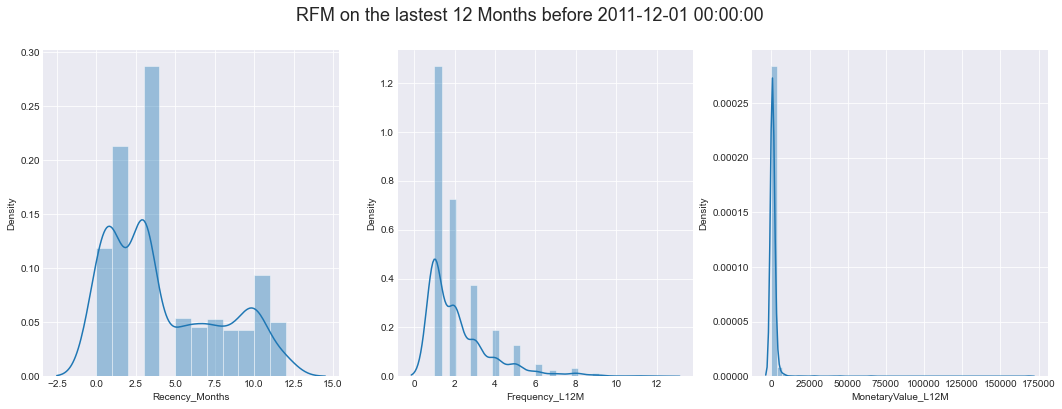

In [17]:
cols_to_plot = [c for c in rfm_df.columns if c != "Customer ID"]

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(18,6), ncols=3)
sns.distplot(rfm_df[cols_to_plot[0]], kde=True, ax=ax1)
sns.distplot(rfm_df[cols_to_plot[1]], kde=True, ax=ax2)
sns.distplot(rfm_df[cols_to_plot[2]], kde=True, ax=ax3)
fig.suptitle(f'RFM on the lastest 12 Months before {comparison_end_month}', fontsize=18)
plt.show()

In [18]:
r_labels = ['Active', 'Lapsed', 'Inactive', 'Churned']
recency_quartiles = pd.qcut(rfm_df['Recency_Months'], q=[0, .25, .50, .75, 1.], labels=r_labels)
recency_quartiles_as_num = pd.qcut(rfm_df['Recency_Months'], q=[0, .25, .50, .75, 1.], labels=range(4,0,-1))
rfm_df['Recency_Group'] = recency_quartiles
rfm_df['Recency_Group_Num'] = recency_quartiles_as_num

f_labels = ['Rare Buyer', 'Occasional Buyer', 'Frequent Buyer']
frequency_quartiles = pd.qcut(rfm_df['Frequency_L12M'], q=[0, .70, .90, 1.], labels=f_labels)
frequency_quartiles_as_num = pd.qcut(rfm_df['Frequency_L12M'], q=[0, .70, .90, 1.], labels=range(1,4))
rfm_df['Frequency_Group'] = frequency_quartiles
rfm_df['Frequency_Group_Num'] = frequency_quartiles_as_num

m_labels = ['Light Spender', 'Medium Spender', 'Good Spender', 'Heavy Spender']
monetary_quartiles = pd.qcut(rfm_df['MonetaryValue_L12M'], q=[0, .25, .50, .75, 1.], labels=m_labels)
monetary_quartiles_as_num = pd.qcut(rfm_df['MonetaryValue_L12M'], q=[0, .25, .50, .75, 1.], labels=range(1,5))
rfm_df['Monetary_Group'] = monetary_quartiles
rfm_df['Monetary_Group_Num'] = monetary_quartiles_as_num

rfm_df['RFM_Segment'] = rfm_df['Recency_Group_Num'].astype(str) + rfm_df['Frequency_Group_Num'].astype(str) + rfm_df['Monetary_Group_Num'].astype(str)
rfm_df['RFM_Score'] = rfm_df[['Recency_Group_Num','Frequency_Group_Num','Monetary_Group_Num']].sum(axis=1)

rfm_df.head(3)

,Customer ID,Recency_Months,Frequency_L12M,MonetaryValue_L12M,Recency_Group,Recency_Group_Num,Frequency_Group,Frequency_Group_Num,Monetary_Group,Monetary_Group_Num,RFM_Segment,RFM_Score
0,12350.0,10.0,1.0,334.4,Churned,1,Rare Buyer,1,Medium Spender,2,112,4
1,12354.0,9.0,1.0,1079.4,Churned,1,Rare Buyer,1,Good Spender,3,113,5
2,12363.0,5.0,2.0,552.0,Inactive,2,Rare Buyer,1,Good Spender,3,213,6


In [19]:
rfm_df.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
111    143
312    111
311    105
112    105
424    100
434     94
211     77
313     71
413     68
423     62
dtype: int64

In [20]:
rfm_df.groupby('RFM_Score').agg({
    'Recency_Months': 'mean',
    'Frequency_L12M': 'mean',
    'MonetaryValue_L12M': ['mean','count']
}).round(1)

Recency_Months Frequency_L12M MonetaryValue_L12M      
                    mean           mean               mean count
RFM_Score                                                       
3                    9.8            1.0              145.2   143
4                    8.2            1.1              278.3   182
5                    5.4            1.2              359.0   209
6                    4.1            1.5              820.3   194
7                    2.8            1.9              983.3   156
8                    2.0            2.4             1141.6   155
9                    1.4            3.0             2641.4   131
10                   0.8            3.9             1954.9   129
11                   0.4            6.5             4599.0    94

In [21]:
def retrieve_cust_medal(RFM_score):
    if RFM_score >= 9:
        return '1 - Gold'
    elif RFM_score >= 6:
        return '2 - Silver'
    else:
        return '3 - Bronze'

rfm_df['General_Segment'] = rfm_df['RFM_Score'].apply(retrieve_cust_medal)
rfm_df.groupby('General_Segment').agg({
    'Recency_Months': 'mean',
    'Frequency_L12M': 'mean',
    'MonetaryValue_L12M': ['mean','count']
}).round(1)

Recency_Months Frequency_L12M MonetaryValue_L12M      
                          mean           mean               mean count
General_Segment                                                       
1 - Gold                   0.9            4.2             2911.1   354
2 - Silver                 3.0            1.9              969.3   505
3 - Bronze                 7.5            1.1              274.2   534

## K-means clustering to segment customers using RFM values

In [22]:
rfm_cols = ['Recency_Months','Frequency_L12M','MonetaryValue_L12M']
rfm_kmeans = rfm_df[['Customer ID'] + rfm_cols].copy()
rfm_kmeans['Customer ID'] = rfm_kmeans['Customer ID'].astype(str)

In [23]:
rfm_kmeans['Recency_Months'] = rfm_kmeans['Recency_Months'] + 1
rfm_kmeans[rfm_cols] = np.log(rfm_kmeans[rfm_cols])

array([[<AxesSubplot:title={'center':'Recency_Months'}>,
        <AxesSubplot:title={'center':'Frequency_L12M'}>],
       [<AxesSubplot:title={'center':'MonetaryValue_L12M'}>,
        <AxesSubplot:>]], dtype=object)

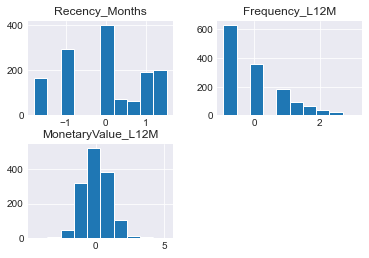

In [24]:
scaler = StandardScaler()
rfm_kmeans[rfm_cols] = scaler.fit_transform(rfm_kmeans[rfm_cols])
rfm_kmeans.hist()

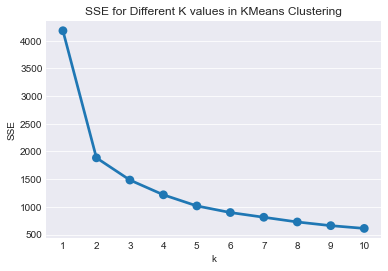

In [25]:
sse = {}
kmeans_cluster_labels = {} 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(rfm_kmeans[rfm_cols])
    sse[k] = kmeans.inertia_
    kmeans_cluster_labels[k] = kmeans.labels_

plt.title('SSE for Different K values in KMeans Clustering')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [26]:
rfm_df['KMeans_Cluster'] = kmeans_cluster_labels[3].astype(str)
rfm_df.groupby('KMeans_Cluster').agg({
    'Recency_Months': 'mean',
    'Frequency_L12M': 'mean',
    'MonetaryValue_L12M': ['mean','count']
}).round(0)

Recency_Months Frequency_L12M MonetaryValue_L12M      
                         mean           mean               mean count
KMeans_Cluster                                                       
0                         7.0            1.0              345.0   673
1                         2.0            2.0             1038.0   464
2                         1.0            5.0             3722.0   256

In [27]:
rfm_kmeans['Cluster'] = kmeans_cluster_labels[3].astype(str)

In [28]:
rfm_kmeans.head()

,Customer ID,Recency_Months,Frequency_L12M,MonetaryValue_L12M,Cluster
0,12350.0,1.305658,-0.951518,-0.436688,0
1,12354.0,1.182955,-0.951518,0.621551,0
2,12363.0,0.525318,0.180031,0.015940,1
3,12364.0,-1.781394,1.311581,0.798540,2
4,12365.0,1.305658,-0.951518,0.151468,0


In [29]:
rfm_kmeans_melted = pd.melt(rfm_kmeans.reset_index(drop=True),
                            id_vars=['Customer ID', 'Cluster'],
                            value_vars=['Recency_Months', 'Frequency_L12M', 'MonetaryValue_L12M'],
                            var_name='Attribute',
                            value_name='Value').replace({'Recency_Months':'Recency', 'Frequency_L12M':'Frequency', 'MonetaryValue_L12M':'MonetaryValue'})

In [30]:
rfm_kmeans_melted.sample(3, random_state=0)

,Customer ID,Cluster,Attribute,Value
3004,13127.0,0,MonetaryValue,-0.666839
888,16022.0,0,Recency,1.305658
2717,18024.0,0,Frequency,-0.951518


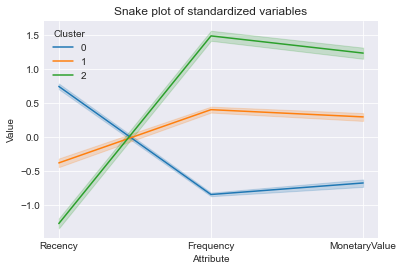

In [31]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=rfm_kmeans_melted)
plt.show()

In [58]:
cluster_avg = rfm_kmeans.groupby('Cluster').mean()
population_avg = rfm_kmeans.drop(columns=['Cluster']).mean()
relative_imp = cluster_avg / population_avg - 1

In [59]:
cluster_avg.round(2)

,Recency_Months,Frequency_L12M,MonetaryValue_L12M
Cluster,,,
0,0.74,-0.84,-0.67
1,-0.38,0.40,0.30
2,-1.27,1.48,1.23


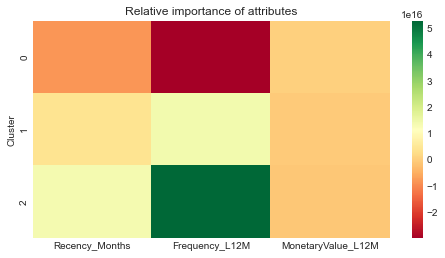

In [60]:
plt.figure(figsize=(8,4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=False, fmt='.2f', cmap='RdYlGn')
plt.show()